In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [47]:
def unpack_acc(directory_path, communicator, epoch=200, datatype='consensus-average', num_tests=5):

    # Enter provided dictionary
    directory = os.path.join(directory_path)
    # Initialize consensus accuracy data matrix for algorithm
    data = np.zeros((num_tests, epoch))

    for root, dirs, files in os.walk(directory):
        # Iterate through all folders in IID/Non-IID Data Folder
        for dir in dirs:
            # Enter sub-folder if it is the communicator we are looking for
            if dir.startswith(communicator):
                result = dir.find('test')
                if dir[result+5].isdigit():
                    test = int(dir[result+4:result+6]) - 1
                else:
                    test = int(dir[result+4]) - 1
                    
                new_directory_path = directory_path + '/' + dir
                new_directory = os.path.join(new_directory_path)
                for root, dirs, files in os.walk(new_directory):
                    for file in files:
                        if file.startswith(datatype):
                            f = open(new_directory_path + '/' + file, 'r')
                            i = 0
                            for line in f:
                                data[test, i] = line
                                i += 1
    return data, np.average(data, axis=0)

In [48]:
def unpack_time(directory_path, communicator, epoch=200, datatype='total-time.log', num_tests=5, num_workers=10):

    directory = os.path.join(directory_path)
    min_data = np.zeros((num_tests, epoch))
    mean_data = np.zeros((num_tests, epoch))
    max_data = np.zeros((num_tests, epoch))

    for root, dirs, files in os.walk(directory):

        for dir in dirs:
            if dir.startswith(communicator):
                result = dir.find('test')
                if dir[result+5].isdigit():
                    test = int(dir[result+4:result+6]) - 1
                else:
                    test = int(dir[result+4]) - 1
                new_directory_path = directory_path + '/' + dir
                new_directory = os.path.join(new_directory_path)
                temp_data = np.zeros((num_workers, epoch))
                for root, dirs, files in os.walk(new_directory):
                    for file in files:
                        if file.endswith(datatype):
                            i = int(file[1])
                            f = open(new_directory_path + '/' + file, 'r')
                            j = 0
                            for line in f:
                                temp_data[i, j] = line
                                j += 1
                if datatype == 'total-time.log':
                    temp_data = np.cumsum(temp_data/60, axis=1)
                    min_idx = np.argmin(temp_data[:, -1])
                    min_data[test, :] = temp_data[min_idx, :]
                mean_data[test, :] = np.average(temp_data, axis=0)
    # Output time in minutes
    return mean_data, min_data

In [49]:
# communicators = ['run-async-iid-5sgdmax-1', 'run-async-iid-5sgdmax-2', 'run-async-pers-iid-5sgdmax-1', 
                 # 'run-async-pers-iid-5sgdmax-2', 'run-dsgd', 'run-pdsgd', 'run-ldsgd']
# labels = ['Ad-FL (1 SGD)', 'Ad-FL (2 SGD)', 'Pad-FL (1 SGD)', 'Pad-FL (2 SGD)', 'D-SGD', 'PD-SGD', 'LD-SGD']
epochs = 200
size = 10
colors = ['r', 'b', 'g', 'm', 'orange']

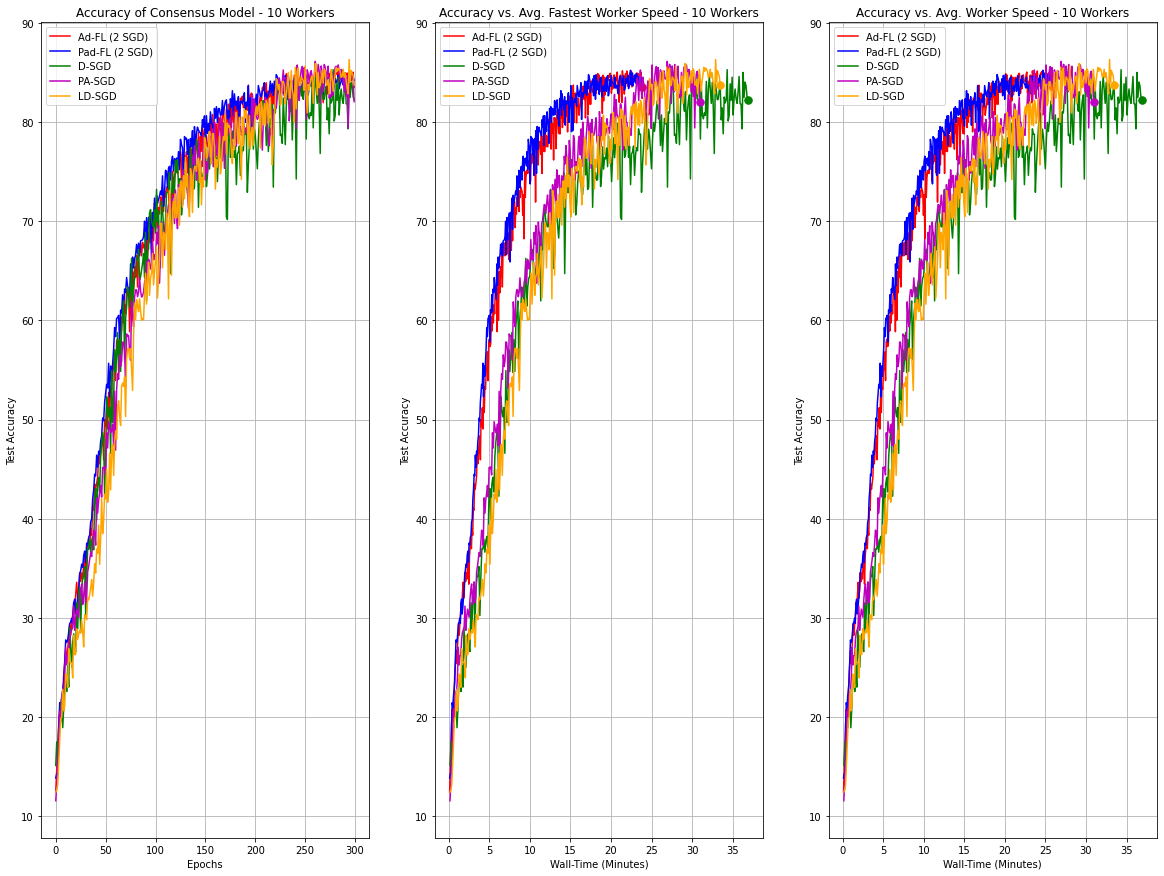

In [50]:
communicators = ['adfed-n', 'padfed-n', 'dsgd', 'pdsgd', 'ldsgd']
labels = ['Ad-FL (2 SGD)', 'Pad-FL (2 SGD)', 'D-SGD', 'PA-SGD', 'LD-SGD']
epochs = 300
# Fully Non-IID Data Plots
i = 0
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
for comm in communicators:
    
    # Get average consensus model accuracy
    acc_data, avg_acc_data = unpack_acc('Output/Full-Experiment', communicator=comm, epoch=epochs)
    avg_max_acc = np.average(np.max(acc_data, axis=1))
    
    # Get average median & minimum run times
    meanTimePerRun, minTimePerRun = unpack_time('Output/Full-Experiment', communicator=comm, epoch=epochs)
    avgMinTime = np.average(minTimePerRun, axis=0)
    avgMeanTime = np.average(meanTimePerRun, axis=0)
    
    x=range(epochs)
    ax1.plot(x, avg_acc_data, label=labels[i], color=colors[i])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Test Accuracy') 
    ax1.set_title('Accuracy of Consensus Model - '+str(size)+' Workers')
    ax1.grid()
    ax1.legend()
    
    ax2.plot(avgMinTime, avg_acc_data, label=labels[i], color=colors[i])
    ax2.plot(avgMinTime[-1], avg_acc_data[-1], marker='o', markersize=7.5, color=colors[i])
    ax2.set_xlabel('Wall-Time (Minutes)')
    ax2.set_ylabel('Test Accuracy') 
    ax2.set_title('Accuracy vs. Avg. Fastest Worker Speed - '+str(size)+' Workers')
    ax2.grid()
    ax2.legend()
    
    ax3.plot(avgMeanTime, avg_acc_data, label=labels[i], color=colors[i])
    ax3.plot(avgMeanTime[-1], avg_acc_data[-1], marker='o', markersize=7.5, color=colors[i])
    ax3.set_xlabel('Wall-Time (Minutes)')
    ax3.set_ylabel('Test Accuracy') 
    ax3.set_title('Accuracy vs. Avg. Worker Speed - '+str(size)+' Workers')
    ax3.grid()
    ax3.legend()
    
    i += 1
plt.show()

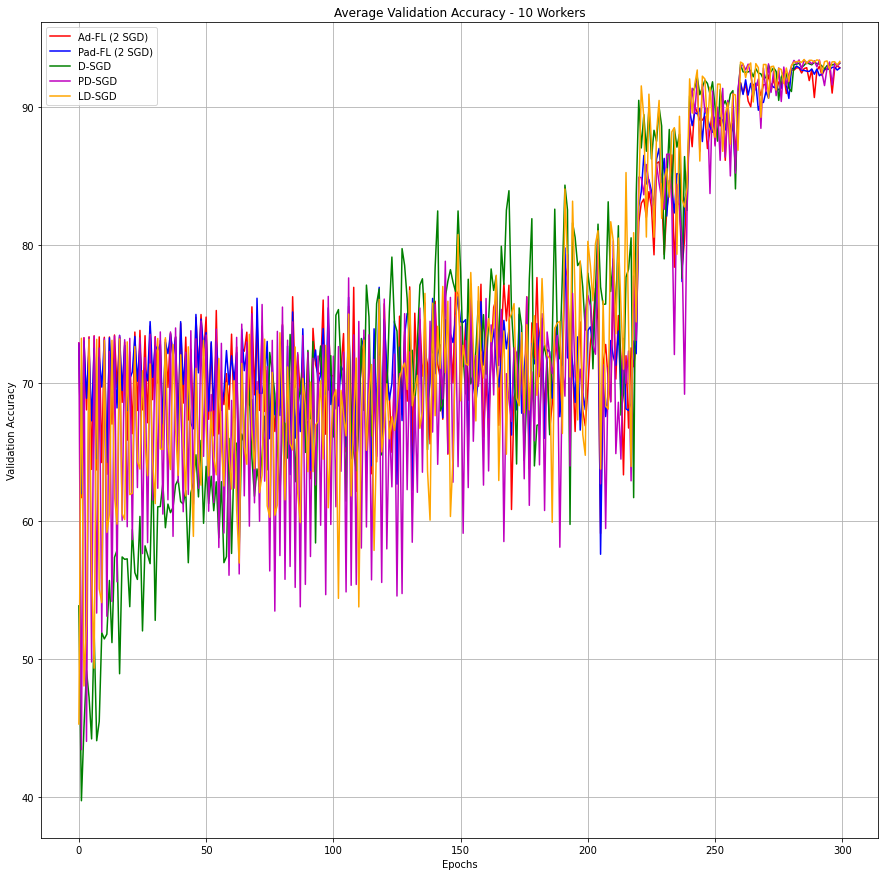

In [51]:
communicators = ['adfed-n', 'padfed-n', 'dsgd', 'pdsgd', 'ldsgd']
labels = ['Ad-FL (2 SGD)', 'Pad-FL (2 SGD)', 'D-SGD', 'PD-SGD', 'LD-SGD']
epochs = 300
size = 10
# IID Personalization Plots
f, (ax1) = plt.subplots(1, 1, figsize=(15,15))
i = 0
for comm in communicators:
    meanValPerRun, minValPerRun = unpack_time('Output/Full-Experiment', communicator=comm, epoch=epochs, datatype='vacc.log')
    avgMeanVal = np.average(meanValPerRun, axis=0)
    x=range(epochs)
    ax1.plot(x, avgMeanVal, label=labels[i], color=colors[i])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Accuracy') 
    ax1.set_title('Average Validation Accuracy - '+str(size)+' Workers')
    ax1.grid()
    ax1.legend()
    i += 1
plt.show()

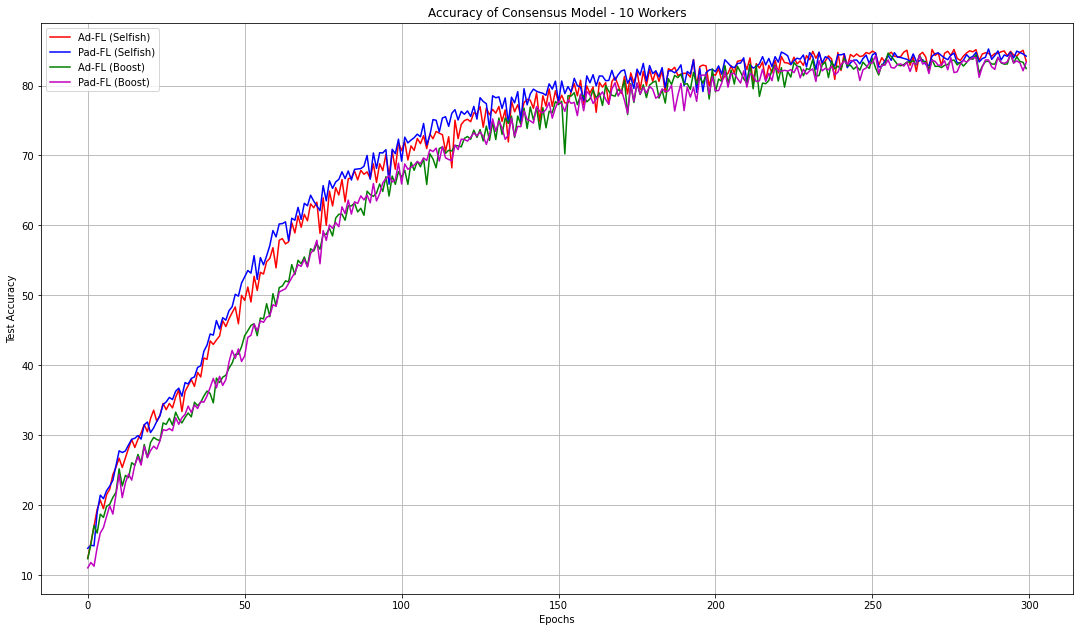

In [52]:
# Compare weight boosting to selfish replacement

communicators = ['adfed-n', 'padfed-n', 'adfed-w', 'padfed-w']
labels = ['Ad-FL (Selfish)', 'Pad-FL (Selfish)', 'Ad-FL (Boost)', 'Pad-FL (Boost)']
epochs = 300
x=range(epochs)
# Fully Non-IID Data Plots
i = 0

for comm in communicators:
    # Get average consensus model accuracy
    acc_data, avg_acc_data = unpack_acc('Output/Full-Experiment', communicator=comm, epoch=epochs)
    plt.plot(x, avg_acc_data, label=labels[i], color=colors[i])
    i += 1
    
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy') 
plt.title('Accuracy of Consensus Model - '+str(size)+' Workers')
plt.grid()
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [53]:
# communicators = ['run-async-iid-5sgdmax-2', 'run-async-pers-iid-5sgdmax-2', 'run-dsgd', 'run-pdsgd', 'run-ldsgd']
# labels = ['Ad-FL (2 SGD)', 'Pad-FL (2 SGD)', 'D-SGD', 'PD-SGD', 'LD-SGD']
# epochs = 200
# size = 5
# # Fully IID Data Plots
# i = 0
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
# for comm in communicators:
    
#     # Get average consensus model accuracy
#     acc_data, avg_acc_data = unpack_acc('Output/Test-IID', communicator=comm)
#     avg_max_acc = np.average(np.max(acc_data, axis=1))
    
#     # Get average median & minimum run times
#     meanTimePerRun, minTimePerRun = unpack_time('Output/Test-IID', communicator=comm)
#     avgMinTime = np.average(minTimePerRun, axis=0)
#     avgMeanTime = np.average(meanTimePerRun, axis=0)
    
#     x=range(epochs)
#     ax1.plot(x, avg_acc_data, label=labels[i], color=colors[i])
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Test Accuracy') 
#     ax1.set_title('Accuracy of Consensus Model - '+str(size)+' Workers')
#     ax1.grid()
#     ax1.legend()
    
#     ax2.plot(avgMinTime, avg_acc_data, label=labels[i], color=colors[i])
#     ax2.plot(avgMinTime[-1], avg_acc_data[-1], marker='o', markersize=7.5, color=colors[i])
#     ax2.set_xlabel('Wall-Time (Minutes)')
#     ax2.set_ylabel('Test Accuracy') 
#     ax2.set_title('Accuracy vs. Avg. Fastest Worker Speed - '+str(size)+' Workers')
#     ax2.grid()
#     ax2.legend()
    
#     ax3.plot(avgMeanTime, avg_acc_data, label=labels[i], color=colors[i])
#     ax3.plot(avgMeanTime[-1], avg_acc_data[-1], marker='o', markersize=7.5, color=colors[i])
#     ax3.set_xlabel('Wall-Time (Minutes)')
#     ax3.set_ylabel('Test Accuracy') 
#     ax3.set_title('Accuracy vs. Avg. Worker Speed - '+str(size)+' Workers')
#     ax3.grid()
#     ax3.legend()
    
#     i += 1
#     # print(avg_acc_data[-5:])
# plt.show()  

In [54]:
# communicators = ['run-async-iid-5sgdmax-2', 'run-async-pers-iid-5sgdmax-2', 'run-dsgd', 'run-pdsgd', 'run-ldsgd']
# labels = ['Ad-FL (2 SGD)', 'Pad-FL (2 SGD)', 'D-SGD', 'PD-SGD', 'LD-SGD']
# epochs = 200
# size = 5
# # IID Personalization Plots
# f, (ax1) = plt.subplots(1, 1, figsize=(15,15))
# i = 0
# for comm in communicators:
#     meanValPerRun, minValPerRun = unpack_time('Output/Test-IID', communicator=comm, datatype='vacc.log')
#     avgMeanVal = np.average(meanValPerRun, axis=0)
#     x=range(epochs)
#     ax1.plot(x, avgMeanVal, label=labels[i], color=colors[i])
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Validation Accuracy') 
#     ax1.set_title('Average Validation Accuracy - '+str(size)+' Workers')
#     ax1.grid()
#     ax1.legend()
#     i += 1
# plt.show()